In [1]:
import larq as lq
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

2024-05-31 10:05:06.139678: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 10:05:06.518536: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 10:05:06.519658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 10:05:07.590909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Helper functions
def print_image(image):
  # Squeeze the third dimension or you can use indexing to select the first slice
  image_2d = np.squeeze(image)

  # Plotting the image
  plt.imshow(image_2d, cmap='gray')  # Use the gray colormap for grayscale
  plt.colorbar()  # Optionally add a colorbar to see the intensity scale
  plt.show()

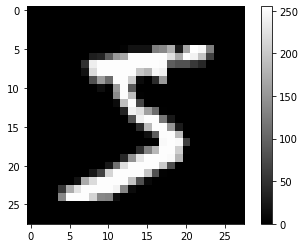

In [6]:
# Prepare dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

print_image(train_images[0])
# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

In [20]:
# NN Topology

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model = tf.keras.models.Sequential()

input_shape = (28, 28, 1) # Input img shape
filters_a = 32 # Number of output channels
kernel_three = (4, 4) # Kernel dimension

filters_b = 32 # Number of output channels
kernel_b = (3, 3) # Kernel dimension

# model.add(lq.layers.QuantConv2D(filters_a, kernel_three,
#                                 input_quantizer="ste_sign",
#                                 kernel_quantizer="ste_sign",
#                                 kernel_constraint="weight_clip",
#                                 use_bias=False,
#                                 input_shape=input_shape))
# model.add(tf.keras.layers.MaxPooling2D((2, 2)))
# model.add(tf.keras.layers.BatchNormalization(scale=False))
# model.add(lq.layers.QuantConv2D(filters_b, kernel_b,
#                                 input_quantizer="ste_sign",
#                                 kernel_quantizer="ste_sign",
#                                 kernel_constraint="weight_clip",
#                                 use_bias=False,
#                                 input_shape=input_shape))
# model.add(tf.keras.layers.MaxPooling2D((2, 2)))
# model.add(tf.keras.layers.BatchNormalization(scale=False))
# model.add(tf.keras.layers.Flatten())
# model.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
# model.add(tf.keras.layers.BatchNormalization(scale=False))
# model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
# model.add(tf.keras.layers.BatchNormalization(scale=False))
# model.add(tf.keras.layers.Activation("softmax"))
model.add(tf.keras.layers.Flatten())
# model.add(lq.layers.QuantDense(500, use_bias=False, **kwargs))
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.Activation("softmax"))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size=64, epochs=6)

Epoch 1/6
938/938 [==============================] - 1s 610us/step - loss: 3.9883 - accuracy: 0.7582
Epoch 2/6
938/938 [==============================] - 1s 570us/step - loss: 3.0133 - accuracy: 0.8225
Epoch 3/6
938/938 [==============================] - 1s 581us/step - loss: 2.9748 - accuracy: 0.8265
Epoch 4/6
938/938 [==============================] - 1s 591us/step - loss: 3.0102 - accuracy: 0.8291
Epoch 5/6
938/938 [==============================] - 1s 571us/step - loss: 3.0290 - accuracy: 0.8293
Epoch 6/6
938/938 [==============================] - 1s 569us/step - loss: 2.9888 - accuracy: 0.8307


In [21]:
# Train NN
test_loss, test_acc = model.evaluate(test_images, test_labels)
lq.models.summary(model)

313/313 [==============================] - 0s 392us/step - loss: 3.1394 - accuracy: 0.8075
+sequential_11 stats--------------------------------------------------+
| Layer           Input prec.    Outputs  # 1-bit  Memory  1-bit MACs |
|                       (bit)                 x 1    (kB)             |
+---------------------------------------------------------------------+
| flatten_4                 -  (-1, 784)        0       0           0 |
| quant_dense_20            1   (-1, 10)     7840    0.96        7840 |
| activation_9              -   (-1, 10)        0       0           ? |
+---------------------------------------------------------------------+
| Total                                      7840    0.96        7840 |
+---------------------------------------------------------------------+
+sequential_11 summary------------------------+
| Total params                      7.84 k    |
| Trainable params                  7.84 k    |
| Non-trainable params              0        

In [71]:
# Extract weights
with lq.context.quantized_scope(True):
    weights = model.layers[1].get_weights()
    print(weights, len(weights[0]), len(weights[0][0]))


# print(weights[0].shape)
# rows, cols, _, output_channels = weights[0].shape
# print(rows, cols, output_channels)
# for col in range(cols):
#     for row in range(rows):
#         for output_channel in range(output_channels):
#             print(row, col, output_channel, weights[0][row][col][0][output_channel])

[array([[-1.,  1.,  1., ..., -1., -1.,  1.],
       [ 1.,  1., -1., ..., -1., -1., -1.],
       [ 1., -1., -1., ..., -1.,  1.,  1.],
       ...,
       [-1.,  1.,  1., ...,  1., -1., -1.],
       [-1.,  1., -1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1.,  1.,  1.]], dtype=float32)] 784 10


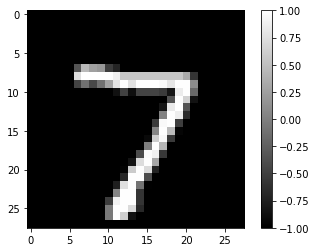

Predicted: 7


In [73]:
print_image(test_images[0]) # test_images[0]
flatten_image = []
for row in test_images[0]:
    for column in row:
        flatten_image.append(column)
flatten_image = np.array(flatten_image).T
fc_classification = np.matmul(flatten_image,weights[0])
prediction = np.argmax(fc_classification)
print("Predicted:", prediction)

In [75]:
def parse_fc(fc_weights):
    fc_weights[fc_weights == -1] = 0
    return fc_weights.T
    # for input_neuron in binarized_weights:
    #     # print(len(input_neuron))

print(parse_fc(weights[0]).shape)

(10, 784)


FileNotFoundError: [Errno 2] No such file or directory: 'gen_hdl/fc_layer.v'